In [ ]:
# === Import required libraries ===
from binance.client import Client
from binance.enums import HistoricalKlinesType
from typing import Union
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# === Function to fetch historical data from Binance ===
def fetch_binance_data(
    symbol: str,
    interval: str = '1h',
    start_time: Union[str, int] = '',
    end_time: Union[str, int] = '',
    kline_type: str = 'futures'
) -> pd.DataFrame:
    if start_time == '' or end_time == '':
        raise ValueError("Must provide start_time & end_time.")

    if kline_type == 'spot':
        t = HistoricalKlinesType.SPOT
    else:
        t = HistoricalKlinesType.FUTURES

    client = Client()
    klines = client.get_historical_klines(
        symbol=symbol,
        interval=interval,
        start_str=start_time,
        end_str=end_time,
        klines_type=t
    )

    cols = [
        "open_time", "open", "high", "low", "close", "volume",
        "close_time", "quote_asset_volume", "num_trades",
        "taker_buy_base", "taker_buy_quote", "ignore"
    ]
    df = pd.DataFrame(klines, columns=cols)
    df[["open", "high", "low", "close", "volume"]] = df[["open", "high", "low", "close", "volume"]].astype(float)
    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms", utc=True)
    df = df[["open_time", "open", "high", "low", "close", "volume"]]
    df.set_index("open_time", inplace=True)
    return df

# === Fetch & merge data ===
eth_df = fetch_binance_data("ETHUSDT", start_time="2021-01-01", end_time="2025-08-01")
ldo_df = fetch_binance_data("LDOUSDT", start_time="2021-01-01", end_time="2025-08-01")

df = eth_df[["close"]].rename(columns={"close": "ETH_Close"}).join(
    ldo_df[["open", "high", "low", "close", "volume"]], how="inner"
)

In [ ]:
# ------------ Strategy Logic ------------
def donchian_high(series, window):
    return series.rolling(window).max()

def donchian_low(series, window):
    return series.rolling(window).min()

def run_strategy(df, donchian_window=20, initial_cash=1_000_000_000, fee=0.0001):
    df = df.copy()
    df["ETH_High"] = donchian_high(df["ETH_Close"], donchian_window)
    df["LDO_Low"] = donchian_low(df["low"], donchian_window)

    df["Entry"] = (df["ETH_Close"] > df["ETH_High"].shift(1))
    in_position = False
    entry_price = 0
    equity = initial_cash
    cash = initial_cash
    position = 0
    equity_curve = []
    trades = []

    for i in range(1, len(df)):
        row = df.iloc[i]
        if not in_position and row["Entry"]:
            entry_price = row["open"] * (1 + fee)
            position = cash / entry_price
            in_position = True
            cash = 0
            trades.append(("BUY", df.index[i], entry_price))

        elif in_position:
            stop = df.iloc[i]["LDO_Low"]
            if row["low"] <= stop:
                exit_price = stop * (1 - fee)
                cash = position * exit_price
                equity = cash
                position = 0
                in_position = False
                trades.append(("SELL", df.index[i], exit_price))

        current_equity = cash if not in_position else position * row["close"]
        equity_curve.append(current_equity)

    df["Equity"] = [np.nan] * (len(df) - len(equity_curve)) + equity_curve
    return df, trades

In [ ]:
# ------ Evaluate strategy ------
def evaluate(df):
    df = df.dropna(subset=["Equity"])
    returns = df["Equity"].pct_change().fillna(0)
    total_return = df["Equity"].iloc[-1] / df["Equity"].iloc[0] - 1
    sharpe = (returns.mean() / returns.std()) * np.sqrt(24 * 365) if returns.std() != 0 else 0
    drawdown = df["Equity"] / df["Equity"].cummax() - 1
    max_dd = drawdown.min()
    cagr = (df["Equity"].iloc[-1] / df["Equity"].iloc[0]) ** (1 / (len(df)/8760)) - 1
    return {
        "Total Return": total_return,
        "Sharpe": sharpe,
        "Max Drawdown": max_dd,
        "CAGR": cagr
    }

In [ ]:
# ------ Backtest train set before Grid Search -------
def backtest_train_set(df: pd.DataFrame, donchian_window: int, initial_cash: float = 1_000_000_000, fee: float = 0.0001):
    """
    Backtest the training set before performing grid search.

    Args:
        df: Full DataFrame containing all data
        donchian_window: int, window size for Donchian Channel
        initial_cash: starting capital
        fee: trading fee

    Returns:
        result_df_train: DataFrame after running the strategy
        metrics_train: dict containing performance metrics
    """
    split_idx = int(len(df) * 0.7)
    train_df = df.iloc[:split_idx]

    result_df_train, trades_train = run_strategy(
        train_df,
        donchian_window=donchian_window,
        initial_cash=initial_cash,
        fee=fee
    )
    metrics_train = evaluate(result_df_train)

    return result_df_train, metrics_train, trades_train

default_window = 20  
result_df_train_default, metrics_train_default, trades_default = backtest_train_set(df, donchian_window=default_window)

print(f"\n--- TRAIN SET with window = {default_window} ---")
for k, v in metrics_train_default.items():
    print(f"{k}: {v:.4f}")


--- TRAIN SET with window = 20 ---
Total Return: -0.5066
Sharpe: 0.0327
Max Drawdown: -0.8319
CAGR: -0.2975


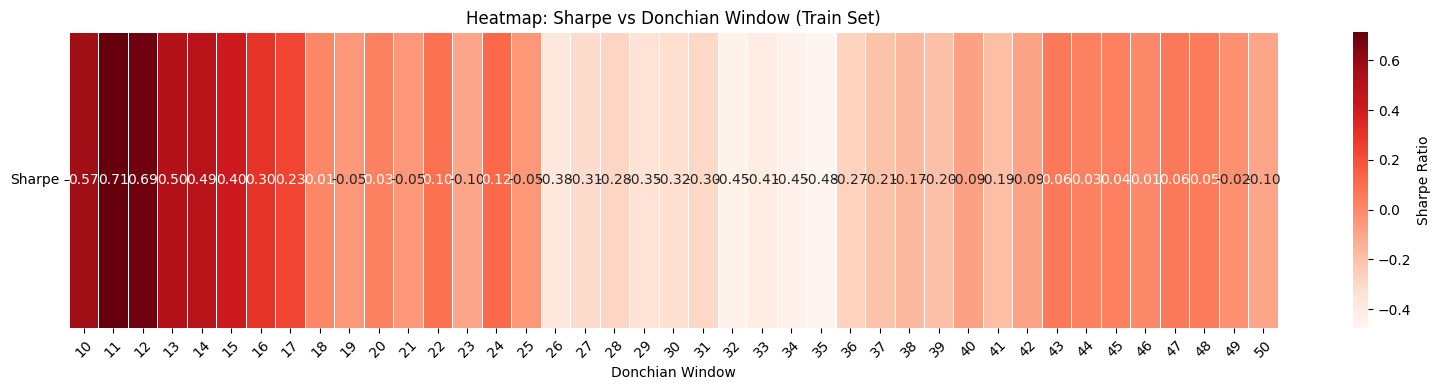

In [ ]:
# ------ Grid Search & Heatmap ------
# Split train/test
split_idx = int(len(df) * 0.7)
train_df = df.iloc[:split_idx]

# Grid search Donchian window from 10 to 50
results = []
for window in range(10, 51):
    result_df_temp, _ = run_strategy(train_df, donchian_window=window)
    metrics = evaluate(result_df_temp)
    results.append((window, metrics["Sharpe"], metrics["Total Return"], metrics["CAGR"], metrics["Max Drawdown"]))

# Create result DataFrame
result_df = pd.DataFrame(results, columns=["Window", "Sharpe", "Total Return", "CAGR", "Max Drawdown"])
result_df.set_index("Window", inplace=True)

# ---- Draw heatmap: Sharpe Ratio ----
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to 1 row so heatmap matches the sample image (image 2)
sharpe_df = result_df[["Sharpe"]].T

plt.figure(figsize=(16, 4))
sns.heatmap(
    sharpe_df,
    annot=True,
    fmt=".2f",
    cmap="Reds",  # red gradient color
    linewidths=0.5,
    cbar_kws={'label': 'Sharpe Ratio'}
)
plt.title("Heatmap: Sharpe vs Donchian Window (Train Set)")
plt.xlabel("Donchian Window")
plt.ylabel("")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

--- TRAIN SET ---
Total Return: 0.5875
Sharpe: 0.7128
Max Drawdown: -0.6839
CAGR: 0.2598

--- TEST SET ---
Total Return: 1.7399
Sharpe: 1.6951
Max Drawdown: -0.3390
CAGR: 2.2388


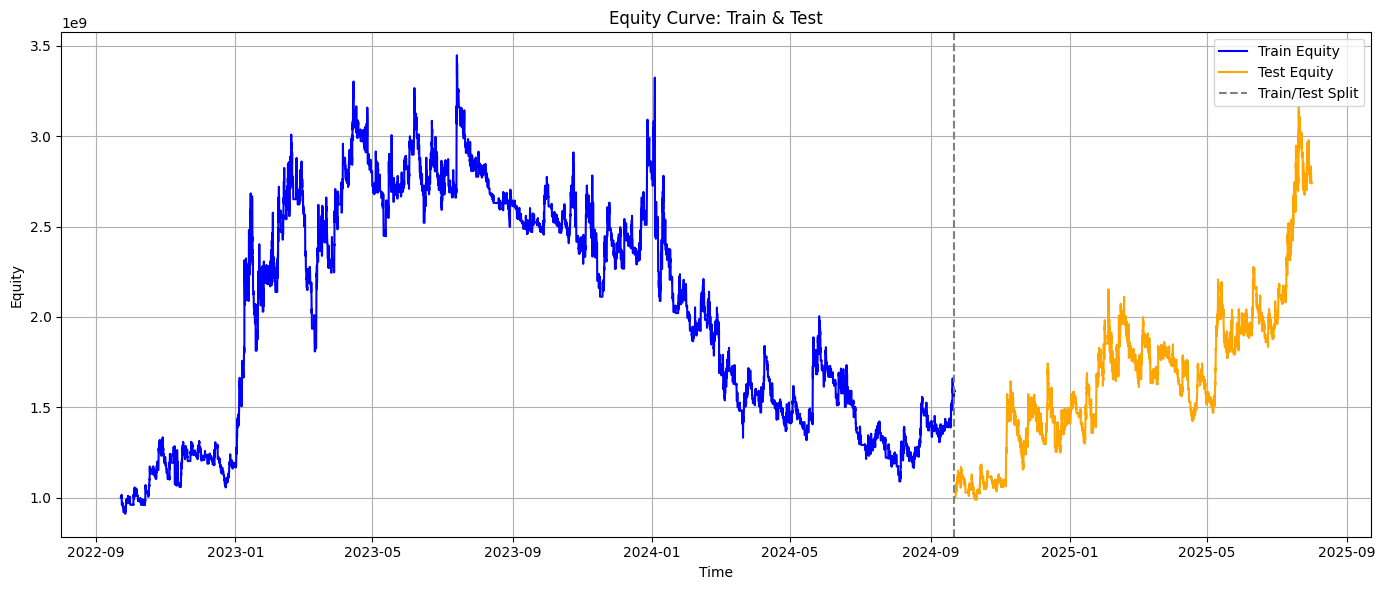

In [ ]:
# ----- Full Backtest -----
def run_full_backtest(df, donchian_window: int, initial_cash: float = 1_000_000_000, fee: float = 0.0001):
    """
    Run backtest on both train and test sets using selected parameter.
    
    Args:
        df: Preprocessed full data DataFrame (1h)
        donchian_window: int, window size for Donchian Channel
        initial_cash: starting capital
        fee: trading fee per entry/exit

    Returns:
        metrics_train, result_df_train, metrics_test, result_df_test
    """
    split_idx = int(len(df) * 0.7)
    train_df = df.iloc[:split_idx]
    test_df = df.iloc[split_idx:]

    # Train Set
    result_df_train, _ = run_strategy(train_df, donchian_window=donchian_window, initial_cash=initial_cash, fee=fee)
    metrics_train = evaluate(result_df_train)

    # Test Set
    result_df_test, _ = run_strategy(test_df, donchian_window=donchian_window, initial_cash=initial_cash, fee=fee)
    metrics_test = evaluate(result_df_test)

    return metrics_train, result_df_train, metrics_test, result_df_test

# Run backtest function
donchian_window = 11  
metrics_train, result_df_train, metrics_test, result_df_test = run_full_backtest(df, donchian_window)

# Print results
print("--- TRAIN SET ---")
for k, v in metrics_train.items():
    print(f"{k}: {v:.4f}")

print("\n--- TEST SET ---")
for k, v in metrics_test.items():
    print(f"{k}: {v:.4f}")

# ---- Plot Equity Curve ----
def plot_equity_curve(result_df_train: pd.DataFrame, result_df_test: pd.DataFrame):
    """
    Plot Equity Curve for both train and test sets.
    
    Args:
        result_df_train: DataFrame with strategy results (train set)
        result_df_test: DataFrame with strategy results (test set)
    """
    plt.figure(figsize=(14, 6))

    # Train
    plt.plot(result_df_train["Equity"], label="Train Equity", color="blue")

    # Test
    plt.plot(result_df_test["Equity"], label="Test Equity", color="orange")

    plt.axvline(x=result_df_test.index[0], color="gray", linestyle="--", label="Train/Test Split")

    plt.title("Equity Curve: Train & Test")
    plt.xlabel("Time")
    plt.ylabel("Equity")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_equity_curve(result_df_train, result_df_test)